In [71]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [74]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib qt

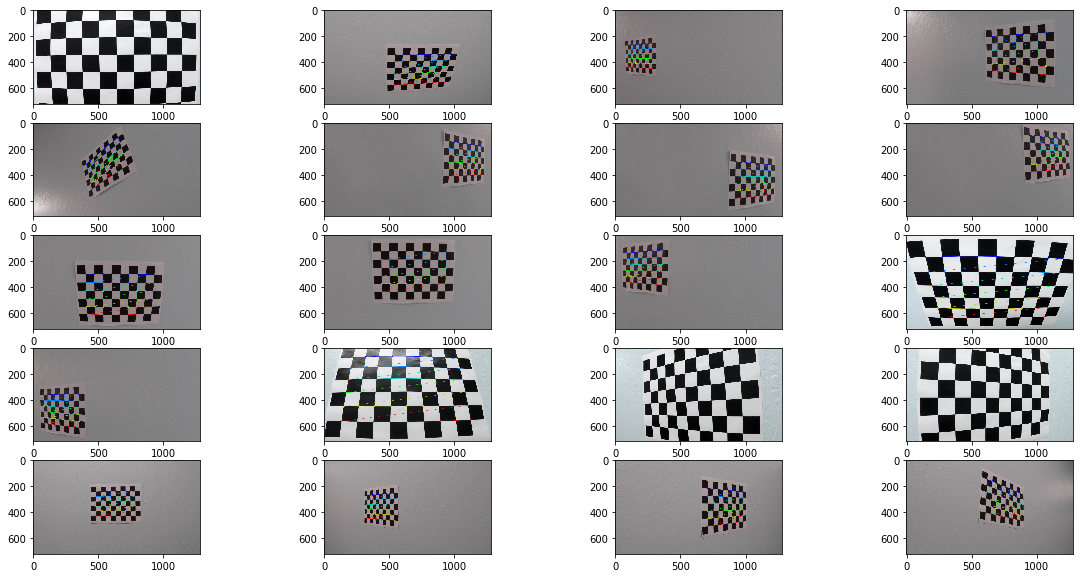

In [40]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
fig=plt.figure(figsize=(20,10))
i=0
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

    plt.subplot(5, 4, i+1)
    plt.imshow(img)
    i+=1

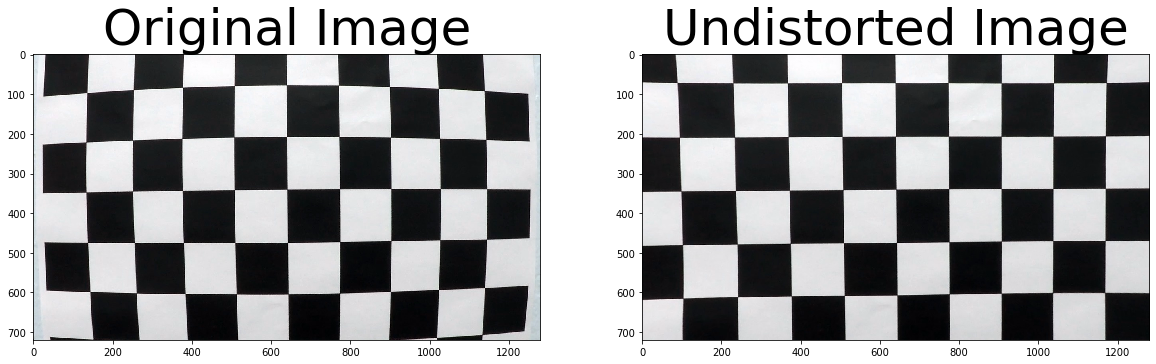

In [61]:
# Now let's test calibration
img = cv2.imread('./camera_cal/calibration1.jpg')

# Camera calibration, given object points, image points, and the shape of the grayscale image
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

#Undistorting a test image:
dst = cv2.undistort(img, mtx, dist, None, mtx)

fig=plt.figure(figsize=(20,10))
fig.tight_layout()
plt.subplot(1, 2, 1)
plt.title('Original Image', fontsize=50)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('Undistorted Image', fontsize=50)
plt.imshow(dst)
plt.savefig('output_images/undistort_output.png',dpi=100);

# Pipeline (single images)

## Step 1: Provide an example of a distortion-corrected image.

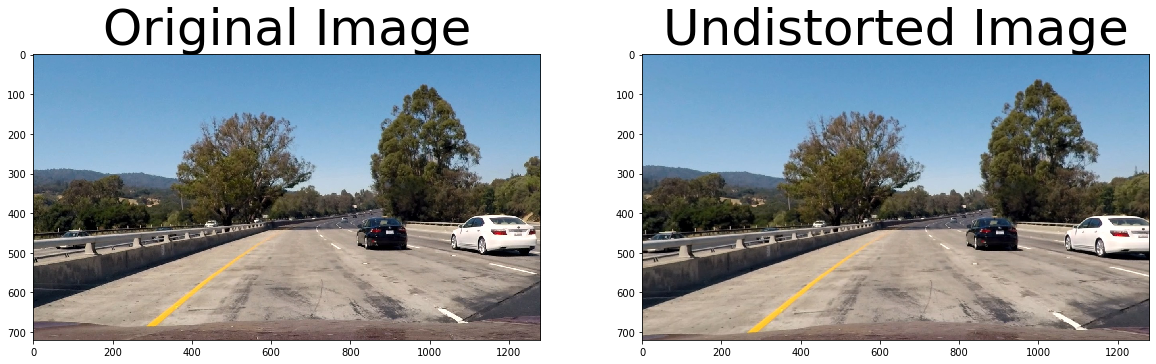

In [92]:
def undistort(img, objpoints, imgpoints):
    # Camera calibration, given object points, image points, and the shape of the grayscale image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    #Undistorting a test image:
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

    
# Now let's test calibration on a real image
img = mpimg.imread('./test_images/test1.jpg')
dst = undistort(img, objpoints, imgpoints)

fig=plt.figure(figsize=(20,10))
fig.tight_layout()
plt.subplot(1, 2, 1)
plt.title('Original Image', fontsize=50)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('Undistorted Image', fontsize=50)
plt.imshow(dst)
plt.savefig('output_images/undistort_test1.png',dpi=100);

## Step 2: Use color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

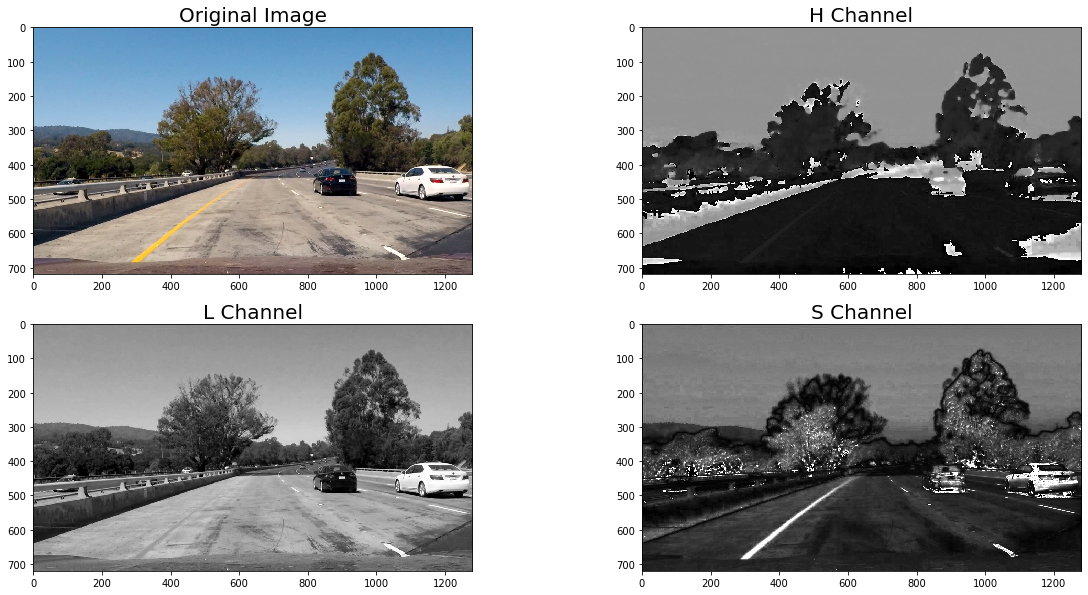

In [110]:
img = mpimg.imread('./test_images/test1.jpg')
fig=plt.figure(figsize=(20,10))
fig.tight_layout()
fig.subplots_adjust(hspace = 0.2,wspace = 0.2)
plt.subplot(2, 2, 1)
plt.title('Original Image', fontsize=20)
plt.imshow(img)
titles = ['H Channel','L Channel','S Channel']
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
for i in range(3):
    ch = hls[:,:,i]
    plt.subplot(2, 2, i+2)
    plt.title(titles[i], fontsize=20)
    plt.imshow(ch, cmap='gray')
    
plt.savefig('output_images/HLScolorchannels_test1.png',dpi=100);

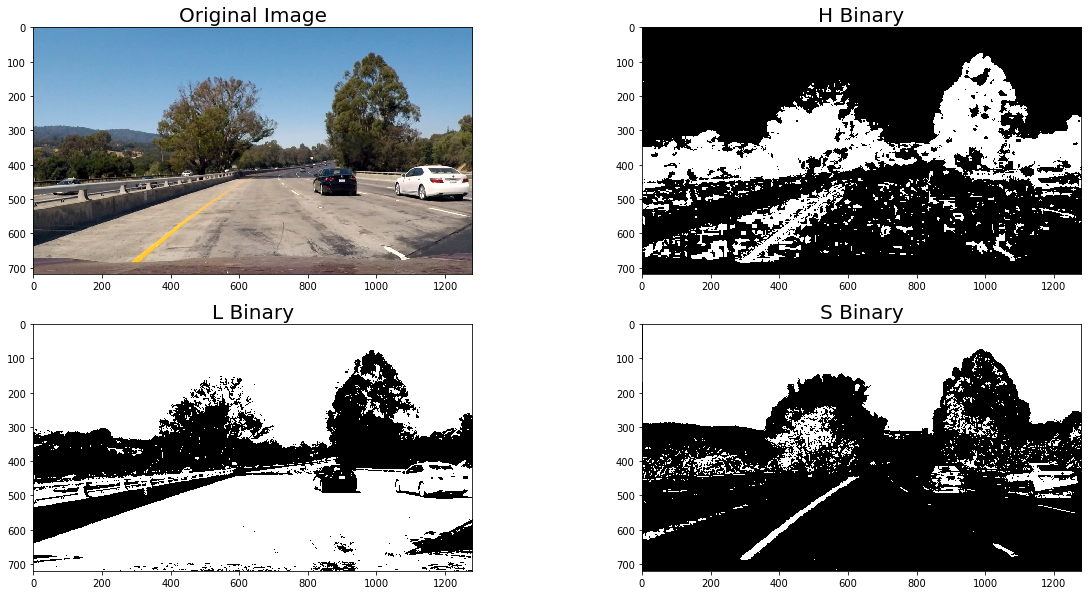

In [108]:
img = mpimg.imread('./test_images/test1.jpg')

fig=plt.figure(figsize=(20,10))
fig.tight_layout()
fig.subplots_adjust(hspace = 0.2,wspace = 0.2)
plt.subplot(2, 2, 1)
plt.title('Original Image', fontsize=20)
plt.imshow(img)
titles = ['H Binary','L Binary','S Binary']
thresh = [(15, 100),(90, 255),(90, 255)]
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
for i in range(3):
    ch = hls[:,:,i]
    binary = np.zeros_like(ch)
    binary[(ch > thresh[i][0]) & (ch <= thresh[i][1])] = 1
    plt.subplot(2, 2, i+2)
    plt.title(titles[i], fontsize=20)
    plt.imshow(binary, cmap='gray')
    
plt.savefig('output_images/HLScolorthreshold_test1.png',dpi=100);

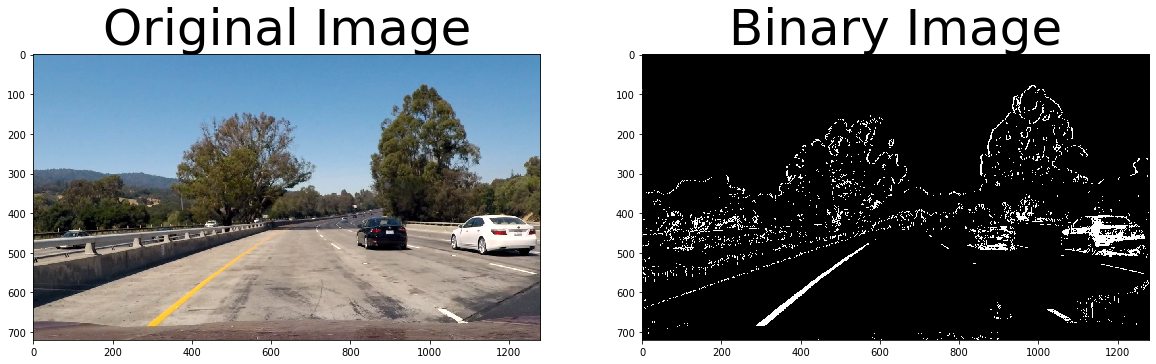

In [103]:
def createBinary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(h_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(sxbinary)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Now combine both
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

# Now let's test it on a real image
img = mpimg.imread('./test_images/test1.jpg')
dst = createBinary(img)

fig=plt.figure(figsize=(20,10))
fig.tight_layout()
plt.subplot(1, 2, 1)
plt.title('Original Image', fontsize=50)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('Binary Image', fontsize=50)
plt.imshow(dst, cmap='gray')
plt.savefig('output_images/binary_test1.png',dpi=100);